# Experiments with Similarity Encoders
## ...to show that SimEc can create similarity preserving embeddings for linear and non-linear similarities (like kernel PCA)
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please refer to [the corresponding paper](http://arxiv.org/abs/1702.01824).

The notebook is structured as follows: After a short toy example, we present several experiments performed on the sklearn handwritten digits dataset (a small real world dataset which works great to quickly test some things out). Then we present the results on the MNIST and 20 newsgroups datasets reported in the original paper.

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA, KernelPCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups
import tensorflow as tf
tf.set_random_seed(28)
import keras

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import SimilarityEncoder, center_K
from utils import load_dataset, get_colors, plot2d, plot3d, plot_digits, plot_mnist, plot_20news, check_embed_match, check_similarity_match

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = True

Using TensorFlow backend.


## Toy Dataset: 3 Circles
Sanity check on an artificially generated toy dataset: Linear similarity encoders reach the same solution as PCA/linear kPCA (up to a rotation and scaling) and nicely map the test examples where they belong.

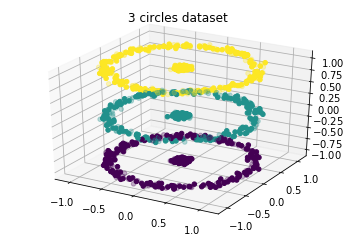

In [2]:
n_train = 1000
n_test = 500
dataset = '3_circles'
# get training and test data
X, Y_plot = load_dataset(dataset, n_train, 3)
X_test, Y_plot_test = load_dataset(dataset, n_test, 5)
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
# plot the original data
plot3d(X, Y_plot, X_test, Y_plot_test, title='%s dataset' % dataset.replace('_', ' '))

similarity approximation       : msqe: 0.0629632072 ; r^2: 0.8971205805 ; rho: 0.9186299240
similarity approximation (test): msqe: 0.0725416555 ; r^2: 0.8727695604 ; rho: 0.8905702688


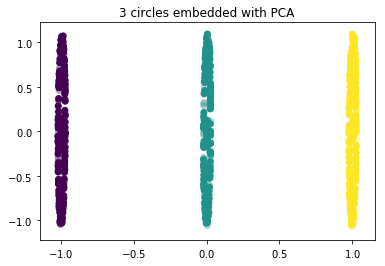

In [3]:
# simple 2D PCA solution
pca = PCA(n_components=2)
X_embed = pca.fit_transform(X)
X_embed_test = pca.transform(X_test)
plot2d(X_embed, Y_plot, X_embed_test, Y_plot_test, 
       title='%s embedded with PCA' % dataset.replace('_', ' '))
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, center_K(np.dot(X, X.T)))
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, center_K(np.dot(X_test, X_test.T)))

Epoch 1/25
1000/1000 [==============================] - 1s 608us/step - loss: 0.7988
Epoch 2/25
1000/1000 [==============================] - 0s 82us/step - loss: 0.4524
Epoch 3/25
1000/1000 [==============================] - 0s 85us/step - loss: 0.2700
Epoch 4/25
1000/1000 [==============================] - 0s 86us/step - loss: 0.2229
Epoch 5/25
1000/1000 [==============================] - 0s 94us/step - loss: 0.1924
Epoch 6/25
1000/1000 [==============================] - 0s 84us/step - loss: 0.1709
Epoch 7/25
1000/1000 [==============================] - 0s 83us/step - loss: 0.1548
Epoch 8/25
1000/1000 [==============================] - 0s 92us/step - loss: 0.1427
Epoch 9/25
1000/1000 [==============================] - 0s 94us/step - loss: 0.1341
Epoch 10/25
1000/1000 [==============================] - 0s 95us/step - loss: 0.1284
Epoch 11/25
1000/1000 [==============================] - 0s 91us/step - loss: 0.1248
Epoch 12/25
1000/1000 [==============================] - 0s 101us/step - 

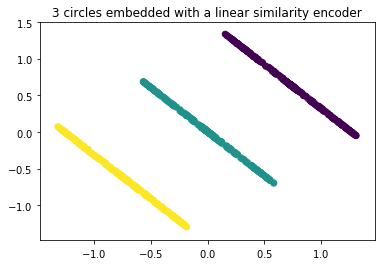

In [4]:
# similarity encoder no activation function, linear similarities as targets
K_lin = center_K(np.dot(X, X.T))
simec = SimilarityEncoder(X.shape[1], 2, K_lin.shape[1], l2_reg_emb=0.01, s_ll_reg=0.5, S_ll=K_lin, opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_lin)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot2d(X_embeds, Y_plot, X_embed_tests, Y_plot_test, 
       title='%s embedded with a linear similarity encoder' % dataset.replace('_', ' '))
print "correlation with PCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with PCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, center_K(np.dot(X_test, X_test.T)))

## Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [5]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
y = digits.target
n_samples, n_features = X.shape

### Linear Similarity
A linear SimEc gets the same solution as PCA (= linear kernel PCA) up to a rotation

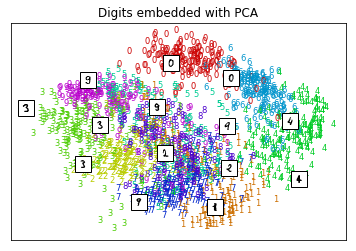

In [6]:
# PCA
pca = PCA(n_components=2)
X_embedp = pca.fit_transform(X)
plot_digits(X_embedp, digits, title='Digits embedded with PCA')

correlation of PCA and linear kPCA: 1.000000
similarity approximation: msqe: 0.7757558402 ; r^2: 0.5362227063 ; rho: 0.7272769661


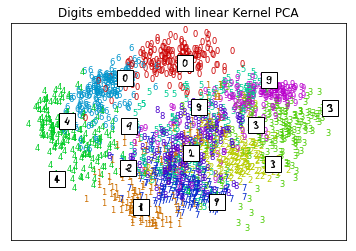

In [7]:
# linear kPCA - same as regular PCA...;)
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with linear Kernel PCA')
print "correlation of PCA and linear kPCA: %f" % check_embed_match(X_embed, X_embedp)[1]
K_lin = center_K(np.dot(X, X.T))
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)

Epoch 1/15
1797/1797 [==============================] - 0s 183us/step - loss: 2.2205
Epoch 2/15
1797/1797 [==============================] - 0s 101us/step - loss: 1.7063
Epoch 3/15
1797/1797 [==============================] - 0s 101us/step - loss: 1.5804
Epoch 4/15
1797/1797 [==============================] - 0s 99us/step - loss: 1.5202
Epoch 5/15
1797/1797 [==============================] - 0s 101us/step - loss: 1.4632
Epoch 6/15
1797/1797 [==============================] - 0s 96us/step - loss: 1.4151
Epoch 7/15
1797/1797 [==============================] - 0s 93us/step - loss: 1.3797
Epoch 8/15
1797/1797 [==============================] - 0s 92us/step - loss: 1.3565
Epoch 9/15
1797/1797 [==============================] - 0s 93us/step - loss: 1.3433
Epoch 10/15
1797/1797 [==============================] - 0s 93us/step - loss: 1.3366
Epoch 11/15
1797/1797 [==============================] - 0s 96us/step - loss: 1.3335
Epoch 12/15
1797/1797 [==============================] - 0s 101us/step

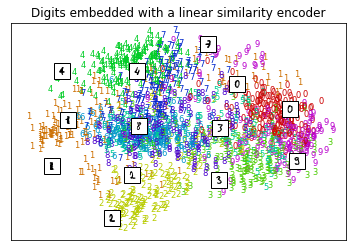

In [8]:
# linear similarity encoder
n_targets = 1000
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_lin[:,:n_targets], epochs=15)
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits embedded with a linear similarity encoder')
print "correlation with linear kPCA: %f" % check_embed_match(X_embed, X_embeds)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)

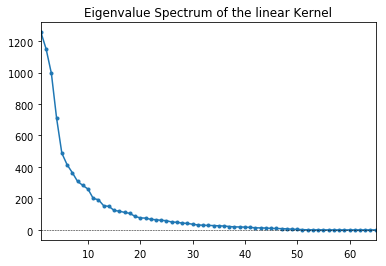

In [9]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(range(1, K_lin.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, X.shape[1]+1);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
1797/1797 [==============================] - 0s 189us/step - loss: 2.2088
Epoch 2/25
1797/1797 [==============================] - 0s 101us/step - loss: 1.6275
Epoch 3/25
1797/1797 [==============================] - 0s 92us/step - loss: 1.5210
Epoch 4/25
1797/1797 [==============================] - 0s 93us/step - loss: 1.4592
Epoch 5/25
1797/1797 [==============================] - 0s 97us/step - loss: 1.3956
Epoch 6/25
1797/1797 [==============================] - 0s 95us/step - loss: 1.3370
Epoch 7/25
1797/1797 [==============================] - 0s 94us/step - loss: 1.2921
Epoch 8/25
1797/1797 [==============================] - 0s 98us/step - loss: 1.2647
Epoch 9/25
1797/1797 [==============================] - 0s 101us/step - loss: 1.2510
Epoch 10/25
1797/1797 [==============================] - 0s 93us/step - loss: 1.2439
Epoch 11/25
1797/1797 [==============================] - 0s 96us/step - loss: 1.2401
Epoch 12/25
1797/1797 [==============================] - 0s 101us/ste

1797/1797 [==============================] - 0s 95us/step - loss: 0.0089
Epoch 12/25
1797/1797 [==============================] - 0s 103us/step - loss: 0.0080
Epoch 13/25
1797/1797 [==============================] - 0s 97us/step - loss: 0.0073
Epoch 14/25
1797/1797 [==============================] - 0s 106us/step - loss: 0.0068
Epoch 15/25
1797/1797 [==============================] - 0s 102us/step - loss: 0.0063
Epoch 16/25
1797/1797 [==============================] - 0s 102us/step - loss: 0.0060
Epoch 17/25
1797/1797 [==============================] - 0s 94us/step - loss: 0.0057
Epoch 18/25
1797/1797 [==============================] - 0s 94us/step - loss: 0.0054
Epoch 19/25
1797/1797 [==============================] - 0s 94us/step - loss: 0.0052
Epoch 20/25
1797/1797 [==============================] - 0s 94us/step - loss: 0.0051
Epoch 21/25
1797/1797 [==============================] - 0s 103us/step - loss: 0.0049
Epoch 22/25
1797/1797 [==============================] - 0s 100us/step -

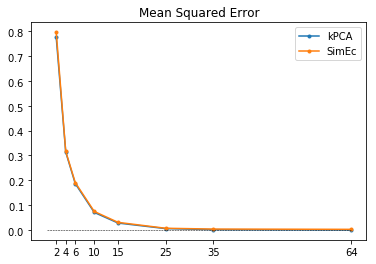

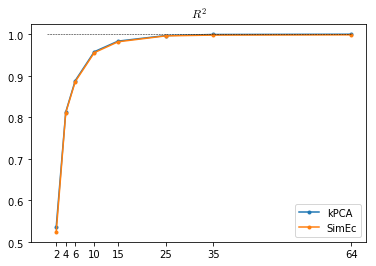

In [10]:
mse_kpca, rsq_kpca = [], []
mse_simec, rsq_simec = [], []
e_dims = [2, 4, 6, 10, 15, 25, 35, X.shape[1]]
for e_dim in e_dims:
    print e_dim
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                              s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], 
                              opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    print "mse kpca: %f; mse simec: %f" % (mse_k, mse)
    print "correlation with linear kPCA: %f" % check_embed_match(X_embed, X_embeds)[1]
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, mse_simec, '-o', markersize=3, label='SimEc');
plt.legend(loc=0);
plt.title('Mean Squared Error');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

### Non-linear similarities
Linear kPCA is straight forward, but what if we use a non-linear kernel function like the Gaussian kernel or isomap?
For the corresponding SimEcs we add some non-linear hidden layers.

similarity approximation: msqe: 0.0063632361 ; r^2: 0.5114399447 ; rho: 0.7355431671


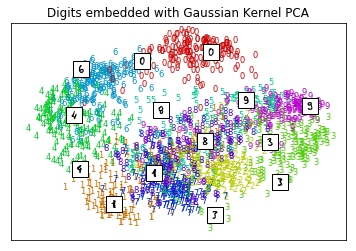

In [11]:
# Gaussian kernel PCA
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)
K_rbf = center_K(rbf_kernel(X, X, gamma))
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with Gaussian Kernel PCA')
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_rbf)

Epoch 1/15
1797/1797 [==============================] - 0s 263us/step - loss: 0.0146
Epoch 2/15
1797/1797 [==============================] - 0s 115us/step - loss: 0.0119
Epoch 3/15
1797/1797 [==============================] - 0s 120us/step - loss: 0.0109
Epoch 4/15
1797/1797 [==============================] - 0s 111us/step - loss: 0.0104
Epoch 5/15
1797/1797 [==============================] - 0s 124us/step - loss: 0.0102
Epoch 6/15
1797/1797 [==============================] - 0s 115us/step - loss: 0.0102
Epoch 7/15
1797/1797 [==============================] - 0s 113us/step - loss: 0.0102
Epoch 8/15
1797/1797 [==============================] - 0s 126us/step - loss: 0.0102
Epoch 9/15
1797/1797 [==============================] - 0s 113us/step - loss: 0.0102
Epoch 10/15
1797/1797 [==============================] - 0s 123us/step - loss: 0.0102
Epoch 11/15
1797/1797 [==============================] - 0s 112us/step - loss: 0.0102
Epoch 12/15
1797/1797 [==============================] - 0s 118

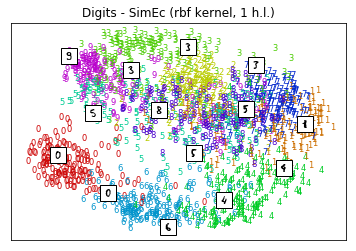

In [12]:
# non-linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], l2_reg=0.00000001,
                          l2_reg_emb=0.0001, l2_reg_out=0.0000001, s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_rbf[:,:n_targets], epochs=15)
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (rbf kernel, 1 h.l.)')
print "correlation with Gaussian kPCA: %f" % check_embed_match(X_embed, X_embeds)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf)

similarity approximation: msqe: 323.1404288696 ; r^2: 0.5824325254 ; rho: -0.7646265148


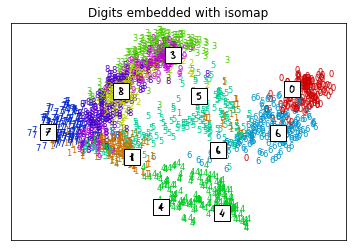

In [13]:
# isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
plot_digits(X_embed, digits, title='Digits embedded with isomap')
K_geod = center_K(isomap.dist_matrix_)
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_geod)

Epoch 1/25
1797/1797 [==============================] - 1s 312us/step - loss: 7.3037
Epoch 2/25
1797/1797 [==============================] - 0s 122us/step - loss: 5.9834
Epoch 3/25
1797/1797 [==============================] - 0s 111us/step - loss: 5.9173
Epoch 4/25
1797/1797 [==============================] - 0s 123us/step - loss: 5.8835
Epoch 5/25
1797/1797 [==============================] - 0s 107us/step - loss: 5.8592
Epoch 6/25
1797/1797 [==============================] - 0s 110us/step - loss: 5.8418
Epoch 7/25
1797/1797 [==============================] - 0s 107us/step - loss: 5.8252
Epoch 8/25
1797/1797 [==============================] - 0s 102us/step - loss: 5.8042
Epoch 9/25
1797/1797 [==============================] - 0s 104us/step - loss: 5.7882
Epoch 10/25
1797/1797 [==============================] - 0s 122us/step - loss: 5.7736
Epoch 11/25
1797/1797 [==============================] - 0s 111us/step - loss: 5.7619
Epoch 12/25
1797/1797 [==============================] - 0s 116

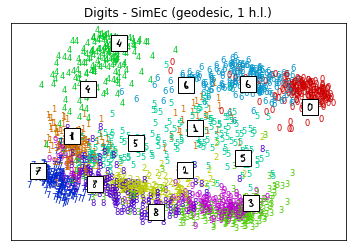

In [14]:
# non-linear SimEc based on isomap
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], s_ll_reg=0.5, 
                          S_ll=K_geod[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (geodesic, 1 h.l.)')
print "correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod)

Epoch 1/25
1797/1797 [==============================] - 1s 338us/step - loss: 3.9841
Epoch 2/25
1797/1797 [==============================] - 0s 134us/step - loss: 2.8169
Epoch 3/25
1797/1797 [==============================] - 0s 123us/step - loss: 2.6989
Epoch 4/25
1797/1797 [==============================] - 0s 127us/step - loss: 2.6507
Epoch 5/25
1797/1797 [==============================] - 0s 132us/step - loss: 2.6177
Epoch 6/25
1797/1797 [==============================] - 0s 124us/step - loss: 2.5965
Epoch 7/25
1797/1797 [==============================] - 0s 123us/step - loss: 2.5844
Epoch 8/25
1797/1797 [==============================] - 0s 126us/step - loss: 2.5723
Epoch 9/25
1797/1797 [==============================] - 0s 134us/step - loss: 2.5628
Epoch 10/25
1797/1797 [==============================] - 0s 140us/step - loss: 2.5545
Epoch 11/25
1797/1797 [==============================] - 0s 141us/step - loss: 2.5476
Epoch 12/25
1797/1797 [==============================] - 0s 126

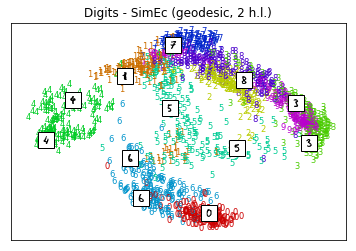

In [15]:
# non-linear SimEc based on isomap - 2 hidden layers
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(200, 'tanh'), (100, 'tanh')],
                          s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.01))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
plot_digits(X_embeds, digits, title='Digits - SimEc (geodesic, 2 h.l.)')
print "correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod)

## MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [16]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
n_targets = 1000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

### Linear Similarity
Linear SimEc again gives the same solution as PCA/linear kPCA.

similarity approximation       : msqe: 51.4531662441 ; r^2: 0.4438507851 ; rho: 0.6341602248
similarity approximation (test): msqe: 50.7905947898 ; r^2: 0.4383615137 ; rho: 0.6283114626


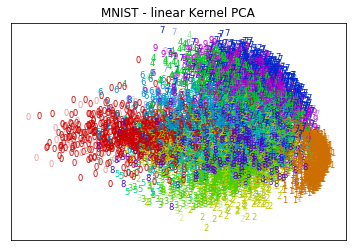

In [17]:
# linear kPCA
K_lin = center_K(np.dot(X, X.T))
K_lin_test = center_K(np.dot(X_test, X_test.T))
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')
if savefigs: plt.savefig('fig_spectral_mnist_lin_kpca.png', dpi=300)
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_lin_test)

Epoch 1/25
8000/8000 [==============================] - 1s 146us/step - loss: 117.3137
Epoch 2/25
8000/8000 [==============================] - 1s 100us/step - loss: 99.1049
Epoch 3/25
8000/8000 [==============================] - 1s 98us/step - loss: 98.2760
Epoch 4/25
8000/8000 [==============================] - 1s 98us/step - loss: 97.9528
Epoch 5/25
8000/8000 [==============================] - 1s 103us/step - loss: 97.6112
Epoch 6/25
8000/8000 [==============================] - 1s 100us/step - loss: 97.1363
Epoch 7/25
8000/8000 [==============================] - 1s 102us/step - loss: 96.4545
Epoch 8/25
8000/8000 [==============================] - 1s 104us/step - loss: 95.4382
Epoch 9/25
8000/8000 [==============================] - 1s 99us/step - loss: 93.9096
Epoch 10/25
8000/8000 [==============================] - 1s 101us/step - loss: 91.7252
Epoch 11/25
8000/8000 [==============================] - 1s 102us/step - loss: 88.8961
Epoch 12/25
8000/8000 [==============================]

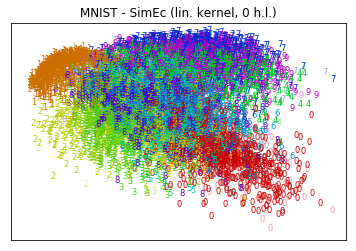

In [18]:
# linear similarity encoder
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.001, l2_reg_out=0.00001, 
                          s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets], 
                          opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_lin[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (lin. kernel, 0 h.l.)')
if savefigs: plt.savefig('fig_spectral_mnist_lin_simec.png', dpi=300)
print "correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_lin_test)

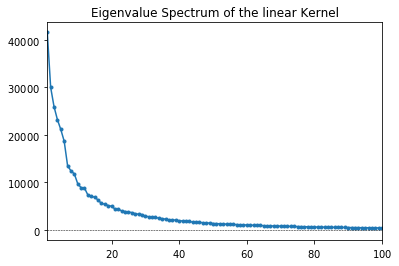

In [19]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(range(1, K_lin.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
8000/8000 [==============================] - 1s 151us/step - loss: 125.8344
Epoch 2/25
8000/8000 [==============================] - 1s 104us/step - loss: 105.9233
Epoch 3/25
8000/8000 [==============================] - 1s 99us/step - loss: 100.9262
Epoch 4/25
8000/8000 [==============================] - 1s 101us/step - loss: 99.8292
Epoch 5/25
8000/8000 [==============================] - 1s 99us/step - loss: 99.1462
Epoch 6/25
8000/8000 [==============================] - 1s 96us/step - loss: 98.6140
Epoch 7/25
8000/8000 [==============================] - 1s 97us/step - loss: 98.1856
Epoch 8/25
8000/8000 [==============================] - 1s 100us/step - loss: 97.8294
Epoch 9/25
8000/8000 [==============================] - 1s 102us/step - loss: 97.4880
Epoch 10/25
8000/8000 [==============================] - 1s 101us/step - loss: 97.1212
Epoch 11/25
8000/8000 [==============================] - 1s 103us/step - loss: 96.6878
Epoch 12/25
8000/8000 [============================

8000/8000 [==============================] - 1s 102us/step - loss: 24.8378
Epoch 15/25
8000/8000 [==============================] - 1s 103us/step - loss: 22.7136
Epoch 16/25
8000/8000 [==============================] - 1s 103us/step - loss: 21.0497
Epoch 17/25
8000/8000 [==============================] - 1s 102us/step - loss: 19.8132
Epoch 18/25
8000/8000 [==============================] - 1s 98us/step - loss: 18.9032
Epoch 19/25
8000/8000 [==============================] - 1s 104us/step - loss: 18.2184
Epoch 20/25
8000/8000 [==============================] - 1s 104us/step - loss: 17.7171
Epoch 21/25
8000/8000 [==============================] - 1s 106us/step - loss: 17.3937
Epoch 22/25
8000/8000 [==============================] - 1s 107us/step - loss: 17.2099
Epoch 23/25
8000/8000 [==============================] - 1s 107us/step - loss: 17.1293
Epoch 24/25
8000/8000 [==============================] - 1s 105us/step - loss: 17.0942
Epoch 25/25
8000/8000 [==============================] -

/home/franzi/anaconda2/lib/python2.7/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (784 < 1000).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


Epoch 1/25
8000/8000 [==============================] - 1s 180us/step - loss: 73.9620
Epoch 2/25
8000/8000 [==============================] - 1s 110us/step - loss: 50.3415
Epoch 3/25
8000/8000 [==============================] - 1s 107us/step - loss: 42.8466
Epoch 4/25
8000/8000 [==============================] - 1s 109us/step - loss: 31.5551
Epoch 5/25
8000/8000 [==============================] - 1s 112us/step - loss: 18.7235
Epoch 6/25
8000/8000 [==============================] - 1s 107us/step - loss: 10.8118
Epoch 7/25
8000/8000 [==============================] - 1s 108us/step - loss: 6.4422
Epoch 8/25
8000/8000 [==============================] - 1s 107us/step - loss: 4.0950
Epoch 9/25
8000/8000 [==============================] - 1s 111us/step - loss: 2.8241
Epoch 10/25
8000/8000 [==============================] - 1s 106us/step - loss: 2.0621
Epoch 11/25
8000/8000 [==============================] - 1s 113us/step - loss: 1.6269
Epoch 12/25
8000/8000 [==============================] - 

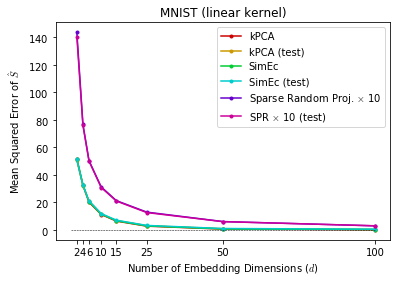

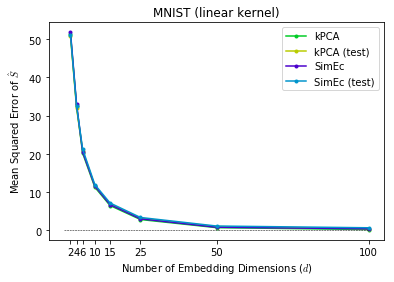

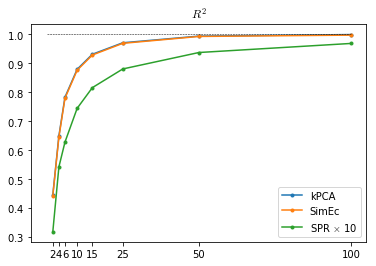

In [20]:
colors = get_colors(15)
mse_rp, mse_rp_test, rsq_rp = [], [], []
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    # random projections
    rp = SparseRandomProjection(n_components=10*e_dim, random_state=42)
    X_embed = rp.fit_transform(X)
    X_embed_test = rp.transform(X_test)
    mse_r, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_rp.append(mse_r)
    rsq_rp.append(rsq)
    mse_rt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_rp_test.append(mse_rt)
    # kpca
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_kpca_test.append(mse_kt)
    # simec
    l = 0.002 if e_dim == 100 else 0.001
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                              l2_reg_emb=l, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print "mse rp: %f (%f); mse kpca: %f (%f); mse simec: %f (%f)" % (mse_r, mse_rt, mse_k, mse_kt, mse, mse_t)
    print "correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
    print "correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[6], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[8], label='SimEc (test)');
plt.plot(e_dims, mse_rp, '-o', markersize=3, c=colors[12], label='Sparse Random Proj. $\\times$ 10');
plt.plot(e_dims, mse_rp_test, '-o', markersize=3, c=colors[14], label='SPR $\\times$ 10 (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
colors = get_colors(10)
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
#plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$')
print "e_dims=", e_dims
print "mse_kpca=", mse_kpca
print "mse_kpca_test=", mse_kpca_test
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot(e_dims, rsq_rp, '-o', markersize=3, label='SPR $\\times$ 10');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

100
Epoch 1/25
8000/8000 [==============================] - 1s 163us/step - loss: 116.4452
Epoch 2/25
8000/8000 [==============================] - 1s 98us/step - loss: 81.2420
Epoch 3/25
8000/8000 [==============================] - 1s 95us/step - loss: 74.5112
Epoch 4/25
8000/8000 [==============================] - 1s 93us/step - loss: 70.6781
Epoch 5/25
8000/8000 [==============================] - 1s 96us/step - loss: 67.7940
Epoch 6/25
8000/8000 [==============================] - 1s 91us/step - loss: 64.3937
Epoch 7/25
8000/8000 [==============================] - 1s 88us/step - loss: 59.4424
Epoch 8/25
8000/8000 [==============================] - 1s 97us/step - loss: 52.6674
Epoch 9/25
8000/8000 [==============================] - 1s 103us/step - loss: 44.8441
Epoch 10/25
8000/8000 [==============================] - 1s 96us/step - loss: 37.2332
Epoch 11/25
8000/8000 [==============================] - 1s 90us/step - loss: 30.7740
Epoch 12/25
8000/8000 [==============================] -

Epoch 19/25
8000/8000 [==============================] - 1s 94us/step - loss: 18.0060
Epoch 20/25
8000/8000 [==============================] - 1s 100us/step - loss: 17.6038
Epoch 21/25
8000/8000 [==============================] - 1s 102us/step - loss: 17.3334
Epoch 22/25
8000/8000 [==============================] - 1s 101us/step - loss: 17.1769
Epoch 23/25
8000/8000 [==============================] - 1s 99us/step - loss: 17.0994
Epoch 24/25
8000/8000 [==============================] - 1s 96us/step - loss: 17.0618
Epoch 25/25
8000/8000 [==============================] - 1s 102us/step - loss: 17.0468
mse kpca: 11.208740 (11.554723); mse simec: 11.571719 (11.920942)
1000
Epoch 1/25
8000/8000 [==============================] - 1s 185us/step - loss: 105.6228
Epoch 2/25
8000/8000 [==============================] - 1s 107us/step - loss: 73.1660
Epoch 3/25
8000/8000 [==============================] - 1s 102us/step - loss: 63.3208
Epoch 4/25
8000/8000 [==============================] - 1s 105us

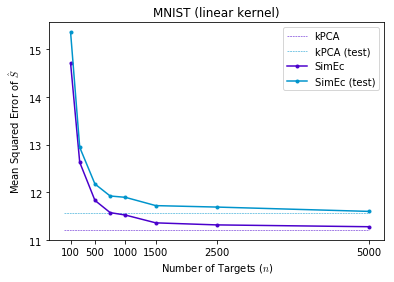

In [21]:
# check effect of different number of targets
colors = get_colors(10)
mse_simec, mse_simec_test = [], []
targets = [100, 250, 500, 750, 1000, 1500, 2500, 5000]
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
for n in targets:
    print n
    simec = SimilarityEncoder(X.shape[1], 10, n, s_ll_reg=0.5, S_ll=K_lin[:n,:n], l2_reg_emb=0.001, 
                              l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin[:,:n])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
plt.figure();
plt.plot([0, targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.xticks([100, 500, 1000, 1500, 2500, 5000], [100, 500, 1000, 1500, 2500, 5000]);
plt.xlabel('Number of Targets ($n$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "targets=", targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_ntargets.pdf', dpi=300)

0.0
Epoch 1/25
8000/8000 [==============================] - 2s 194us/step - loss: 105.1319
Epoch 2/25
8000/8000 [==============================] - 1s 116us/step - loss: 71.0329
Epoch 3/25
8000/8000 [==============================] - 1s 115us/step - loss: 64.4809
Epoch 4/25
8000/8000 [==============================] - 1s 115us/step - loss: 59.0525
Epoch 5/25
8000/8000 [==============================] - 1s 119us/step - loss: 55.6501
Epoch 6/25
8000/8000 [==============================] - 1s 114us/step - loss: 52.8754
Epoch 7/25
8000/8000 [==============================] - 1s 116us/step - loss: 49.1194
Epoch 8/25
8000/8000 [==============================] - 1s 112us/step - loss: 43.9179
Epoch 9/25
8000/8000 [==============================] - 1s 118us/step - loss: 37.7790
Epoch 10/25
8000/8000 [==============================] - 1s 119us/step - loss: 31.9722
Epoch 11/25
8000/8000 [==============================] - 1s 112us/step - loss: 27.2589
Epoch 12/25
8000/8000 [========================

8000/8000 [==============================] - 1s 114us/step - loss: 18.0551
Epoch 19/25
8000/8000 [==============================] - 1s 119us/step - loss: 17.6127
Epoch 20/25
8000/8000 [==============================] - 1s 113us/step - loss: 17.3720
Epoch 21/25
8000/8000 [==============================] - 1s 119us/step - loss: 17.2555
Epoch 22/25
8000/8000 [==============================] - 1s 109us/step - loss: 17.2042
Epoch 23/25
8000/8000 [==============================] - 1s 112us/step - loss: 17.1818
Epoch 24/25
8000/8000 [==============================] - 1s 111us/step - loss: 17.1735
Epoch 25/25
8000/8000 [==============================] - 1s 118us/step - loss: 17.1691
mse kpca: 11.208740 (11.554723); mse simec: 11.523021 (11.896341)
0.4
Epoch 1/25
8000/8000 [==============================] - 2s 220us/step - loss: 107.5219
Epoch 2/25
8000/8000 [==============================] - 1s 115us/step - loss: 74.5690
Epoch 3/25
8000/8000 [==============================] - 1s 113us/step - l

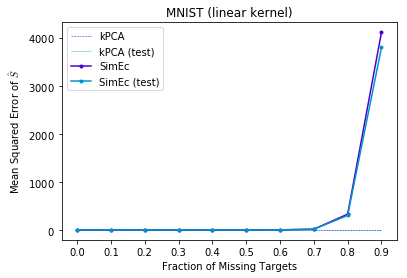

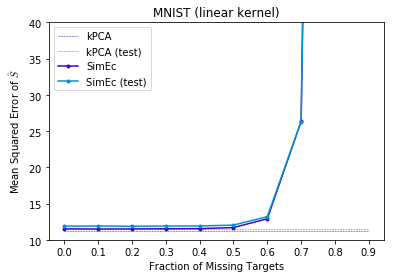

In [22]:
# missing targets
n_targets = 1000
np.random.seed(15)
colors = get_colors(10)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print m
    K_lin_noisy = K_lin.copy()
    K_lin_noisy[np.random.rand(*K_lin_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, mask_value=-100, s_ll_reg=0.5, 
                              S_ll=K_lin_noisy[:n_targets,:n_targets], l2_reg_emb=0.01, 
                              l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.003))
    simec.fit(X, K_lin_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.ylim([10, 40])
plt.title('MNIST (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "missing_targets=", missing_targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_mnist_lin_mse_missingt.pdf', dpi=300)

### Non-linear Similarities
Isomap and corresponding SimEc with 2 hidden layers.

similarity approximation: msqe: 18028.5596162775 ; r^2: 0.4349227535 ; rho: -0.6522184999


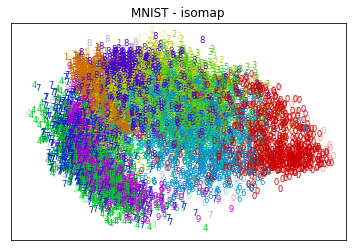

In [23]:
# isomap
n_targets = 1000
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
X_embed_test = isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')
K_geod = center_K(isomap.dist_matrix_)
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_geod)

Epoch 1/25
8000/8000 [==============================] - 2s 244us/step - loss: 28.5373
Epoch 2/25
8000/8000 [==============================] - 1s 140us/step - loss: 24.2904
Epoch 3/25
8000/8000 [==============================] - 1s 135us/step - loss: 23.9958
Epoch 4/25
8000/8000 [==============================] - 1s 128us/step - loss: 23.8707
Epoch 5/25
8000/8000 [==============================] - 1s 136us/step - loss: 23.7921
Epoch 6/25
8000/8000 [==============================] - 1s 133us/step - loss: 23.7345
Epoch 7/25
8000/8000 [==============================] - 1s 136us/step - loss: 23.6938
Epoch 8/25
8000/8000 [==============================] - 1s 135us/step - loss: 23.6653
Epoch 9/25
8000/8000 [==============================] - 1s 136us/step - loss: 23.6288
Epoch 10/25
8000/8000 [==============================] - 1s 133us/step - loss: 23.6169
Epoch 11/25
8000/8000 [==============================] - 1s 132us/step - loss: 23.5984
Epoch 12/25
8000/8000 [=============================

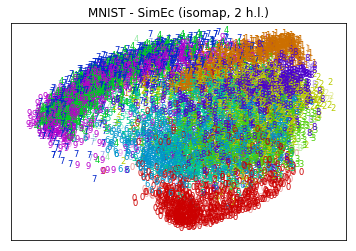

In [24]:
# non-linear SimEc to approximate isomap solution
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(200, 'tanh'), (100, 'tanh')], l2_reg=0.0005, 
                          l2_reg_emb=0.001, l2_reg_out=0.000001, opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_geod[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (isomap, 2 h.l.)')
print "correlation with isomap: %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with isomap (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod)

gamma: 0.00475
similarity approximation       : msqe: 0.0017745004 ; r^2: 0.4544257374 ; rho: 0.6513194244
similarity approximation (test): msqe: 0.0017821277 ; r^2: 0.4476707996 ; rho: 0.6471248815


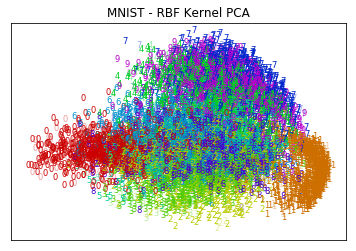

In [25]:
# Gaussian kernel PCA
D = squareform(pdist(X, 'euclidean'))
sigma = np.median(D)
gamma = 0.5/(sigma**2)
print "gamma: %.5f" % gamma
K_rbf_nonc = rbf_kernel(X, X, gamma)
K_rbf = center_K(K_rbf_nonc)
K_rbf_test_nonc = rbf_kernel(X_test, X_test, gamma)
K_rbf_test = center_K(K_rbf_test_nonc)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - RBF Kernel PCA')
if savefigs: plt.savefig('fig_spectral_mnist_rbf_kpca.png', dpi=300)
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_rbf)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_rbf_test)

Epoch 1/25
8000/8000 [==============================] - 2s 225us/step - loss: 0.0053
Epoch 2/25
8000/8000 [==============================] - 1s 116us/step - loss: 0.0045
Epoch 3/25
8000/8000 [==============================] - 1s 116us/step - loss: 0.0039
Epoch 4/25
8000/8000 [==============================] - 1s 116us/step - loss: 0.0037
Epoch 5/25
8000/8000 [==============================] - 1s 111us/step - loss: 0.0036
Epoch 6/25
8000/8000 [==============================] - 1s 113us/step - loss: 0.0035
Epoch 7/25
8000/8000 [==============================] - 1s 112us/step - loss: 0.0034
Epoch 8/25
8000/8000 [==============================] - 1s 113us/step - loss: 0.0033
Epoch 9/25
8000/8000 [==============================] - 1s 114us/step - loss: 0.0033
Epoch 10/25
8000/8000 [==============================] - 1s 113us/step - loss: 0.0032
Epoch 11/25
8000/8000 [==============================] - 1s 112us/step - loss: 0.0031
Epoch 12/25
8000/8000 [==============================] - 1s 112

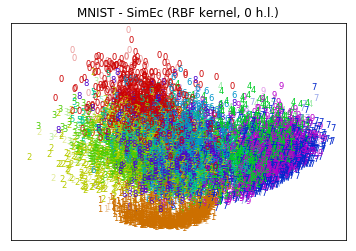

In [26]:
# linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0003))
simec.fit(X, K_rbf[:,:n_targets], epochs=25)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (RBF kernel, 0 h.l.)')
print "correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_rbf_test)

Epoch 1/25
8000/8000 [==============================] - 2s 267us/step - loss: 0.0049
Epoch 2/25
8000/8000 [==============================] - 1s 139us/step - loss: 0.0042
Epoch 3/25
8000/8000 [==============================] - 1s 139us/step - loss: 0.0037
Epoch 4/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.0035
Epoch 5/25
8000/8000 [==============================] - 1s 143us/step - loss: 0.0034
Epoch 6/25
8000/8000 [==============================] - 1s 136us/step - loss: 0.0034
Epoch 7/25
8000/8000 [==============================] - 1s 137us/step - loss: 0.0033
Epoch 8/25
8000/8000 [==============================] - 1s 136us/step - loss: 0.0032
Epoch 9/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.0032
Epoch 10/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.0031
Epoch 11/25
8000/8000 [==============================] - 1s 139us/step - loss: 0.0030
Epoch 12/25
8000/8000 [==============================] - 1s 141

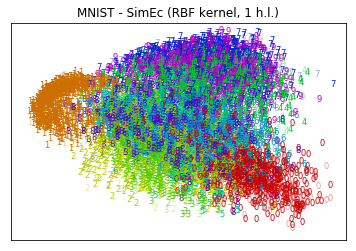

In [27]:
# non-linear SimEc with rbf kernel
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(1000, 'tanh')], l2_reg=0.00000001, 
                          l2_reg_emb=0.00001, l2_reg_out=0.0000001, s_ll_reg=0.5, 
                          S_ll=K_rbf[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0003))
simec.fit(X, K_rbf[:,:n_targets], epochs=25)
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (RBF kernel, 1 h.l.)')
if savefigs: plt.savefig('fig_spectral_mnist_rbf_simec.png', dpi=300)
print "correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_rbf)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_rbf_test)

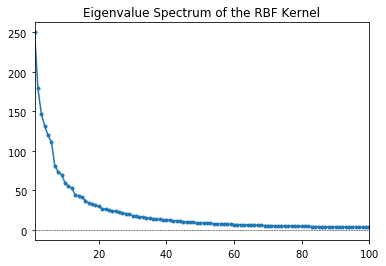

In [28]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_rbf)[::-1]
plt.figure();
plt.plot(range(1, K_rbf.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, K_rbf.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the RBF Kernel');

2
Epoch 1/25
8000/8000 [==============================] - 2s 266us/step - loss: 0.0047
Epoch 2/25
8000/8000 [==============================] - 1s 137us/step - loss: 0.0038
Epoch 3/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.0034
Epoch 4/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.0034
Epoch 5/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.0033
Epoch 6/25
8000/8000 [==============================] - 1s 134us/step - loss: 0.0032
Epoch 7/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.0031
Epoch 8/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.0030
Epoch 9/25
8000/8000 [==============================] - 1s 138us/step - loss: 0.0029
Epoch 10/25
8000/8000 [==============================] - 1s 135us/step - loss: 0.0028
Epoch 11/25
8000/8000 [==============================] - 1s 136us/step - loss: 0.0028
Epoch 12/25
8000/8000 [==============================] - 1s 1

correlation with kPCA       : 0.976597
correlation with kPCA (test): 0.975414
100
Epoch 1/25
8000/8000 [==============================] - 2s 295us/step - loss: 0.0067
Epoch 2/25
8000/8000 [==============================] - 1s 148us/step - loss: 0.0039
Epoch 3/25
8000/8000 [==============================] - 1s 147us/step - loss: 0.0032
Epoch 4/25
8000/8000 [==============================] - 1s 149us/step - loss: 0.0025
Epoch 5/25
8000/8000 [==============================] - 1s 152us/step - loss: 0.0019
Epoch 6/25
8000/8000 [==============================] - 1s 150us/step - loss: 0.0014
Epoch 7/25
8000/8000 [==============================] - 1s 150us/step - loss: 0.0012
Epoch 8/25
8000/8000 [==============================] - 1s 149us/step - loss: 9.3654e-04
Epoch 9/25
8000/8000 [==============================] - 1s 147us/step - loss: 7.6405e-04
Epoch 10/25
8000/8000 [==============================] - 1s 149us/step - loss: 6.2833e-04
Epoch 11/25
8000/8000 [==============================] 

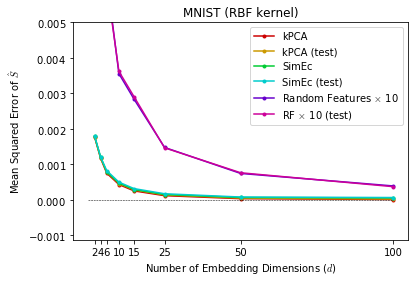

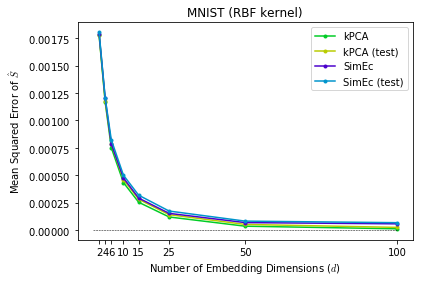

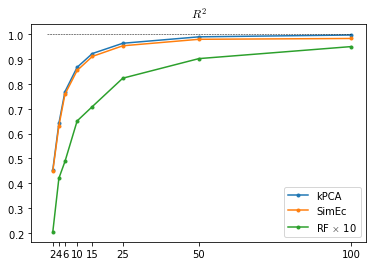

In [29]:
colors = get_colors(15)
mse_rf, mse_rf_test, rsq_rf = [], [], []
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    # random features
    W = np.random.normal(size=(5*e_dim, X.shape[1]), scale=1./sigma)
    tmp = X.dot(W.T)
    X_embed = np.sqrt(1./(5*e_dim)) * np.hstack([np.cos(tmp), np.sin(tmp)])
    tmp = X_test.dot(W.T)
    X_embed_test = np.sqrt(1./(5*e_dim)) * np.hstack([np.cos(tmp), np.sin(tmp)])
    mse_r, rsq, _ = check_similarity_match(X_embed, K_rbf_nonc)
    mse_rf.append(mse_r)
    rsq_rf.append(rsq)
    mse_rt, _, _ = check_similarity_match(X_embed_test, K_rbf_test_nonc)
    mse_rf_test.append(mse_rt)
    # kernel pca
    kpca = KernelPCA(n_components=e_dim, kernel='rbf', gamma=gamma)
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_rbf)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_rbf_test)
    mse_kpca_test.append(mse_kt)
    # simec
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              s_ll_reg=0.5, S_ll=K_rbf[:n_targets,:n_targets], 
                              opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_rbf)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_rbf_test)
    mse_simec_test.append(mse_t)
    print "mse rf: %f (%f); mse kpca: %f (%f); mse simec: %f (%f)" % (mse_r, mse_rt, mse_k, mse_kt, mse, mse_t)
    print "correlation with kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
    print "correlation with kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[6], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[8], label='SimEc (test)');
plt.plot(e_dims, mse_rf, '-o', markersize=3, c=colors[12], label='Random Features $\\times$ 10');
plt.plot(e_dims, mse_rf_test, '-o', markersize=3, c=colors[14], label='RF $\\times$ 10 (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.ylim(ymax=0.005)
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
plt.figure();
colors = get_colors(10)
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "e_dims=", e_dims
print "mse_kpca=", mse_kpca
print "mse_kpca_test=", mse_kpca_test
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_mnist_rbf_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot(e_dims, rsq_rf, '-o', markersize=3, label='RF $\\times$ 10');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

0.0
Epoch 1/25
8000/8000 [==============================] - 2s 305us/step - loss: 0.0044
Epoch 2/25
8000/8000 [==============================] - 1s 150us/step - loss: 0.0029
Epoch 3/25
8000/8000 [==============================] - 1s 152us/step - loss: 0.0023
Epoch 4/25
8000/8000 [==============================] - 1s 150us/step - loss: 0.0019
Epoch 5/25
8000/8000 [==============================] - 1s 150us/step - loss: 0.0015
Epoch 6/25
8000/8000 [==============================] - 1s 154us/step - loss: 0.0012
Epoch 7/25
8000/8000 [==============================] - 1s 148us/step - loss: 0.0010
Epoch 8/25
8000/8000 [==============================] - 1s 147us/step - loss: 9.1086e-04
Epoch 9/25
8000/8000 [==============================] - 1s 151us/step - loss: 8.6431e-04
Epoch 10/25
8000/8000 [==============================] - 1s 150us/step - loss: 8.4474e-04
Epoch 11/25
8000/8000 [==============================] - 1s 152us/step - loss: 8.2707e-04
Epoch 12/25
8000/8000 [====================

8000/8000 [==============================] - 1s 154us/step - loss: 0.0022
Epoch 6/25
8000/8000 [==============================] - 1s 155us/step - loss: 0.0019
Epoch 7/25
8000/8000 [==============================] - 1s 151us/step - loss: 0.0017
Epoch 8/25
8000/8000 [==============================] - 1s 156us/step - loss: 0.0014
Epoch 9/25
8000/8000 [==============================] - 1s 155us/step - loss: 0.0011
Epoch 10/25
8000/8000 [==============================] - 1s 154us/step - loss: 9.8686e-04
Epoch 11/25
8000/8000 [==============================] - 1s 151us/step - loss: 9.0473e-04
Epoch 12/25
8000/8000 [==============================] - 1s 153us/step - loss: 8.5329e-04
Epoch 13/25
8000/8000 [==============================] - 1s 155us/step - loss: 8.1951e-04
Epoch 14/25
8000/8000 [==============================] - 1s 157us/step - loss: 7.9802e-04
Epoch 15/25
8000/8000 [==============================] - 1s 157us/step - loss: 7.8305e-04
Epoch 16/25
8000/8000 [=======================

Text(0,0.5,u'Mean Squared Error of $\\hat{S}$')

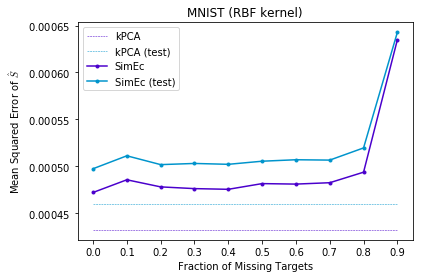

In [30]:
# missing targets
n_targets = 1000
np.random.seed(15)
colors = get_colors(10)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_rbf)[0]
mse_kt = check_similarity_match(X_embed_test, K_rbf_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print m
    K_rbf_noisy = K_rbf.copy()
    K_rbf_noisy[np.random.rand(*K_rbf_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              mask_value=-100, s_ll_reg=0.5, S_ll=K_rbf_noisy[:n_targets,:n_targets])
    simec.fit(X, K_rbf_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_rbf)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_rbf_test)[0]
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets');
plt.ylabel('Mean Squared Error of $\hat{S}$');

## 20 Newsgroups
To show that SimEc embeddings can also be computed for other types of data, we do some further experiments with the 20 newsgroups dataset. We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`). The posts are transformed into very high dimensional tf-idf vectors used as input to the SimEc and to compute the linear kernel matrix.

In [31]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
target_names = newsgroups_train.target_names
n_targets = 1000

3959 training and 2359 test samples
45813 features


### Linear Similarity
Again, linear kPCA and SimEc give the same solution (up to a rotation). Btw, here we can't use regular PCA as the covariance matrix would be very high dimensional and poorly estimated due to the small amount of samples.

similarity approximation       : msqe: 0.0331868908 ; r^2: 0.2263374840 ; rho: 0.6310964767
similarity approximation (test): msqe: 0.0421617582 ; r^2: 0.1775899837 ; rho: 0.6165146584


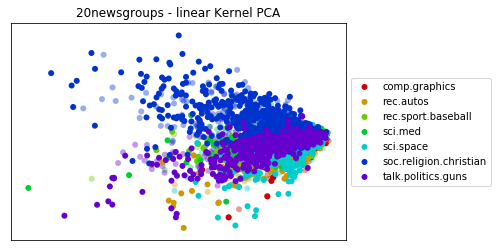

In [32]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20newsgroups - linear Kernel PCA', legend=True)
if savefigs: plt.savefig('fig_spectral_20news_lin_kpca.png', dpi=300)
# compute linear kernel and center
K_lin = center_K(X.dot(X.T).A)
K_lin_test = center_K(X_test.dot(X_test.T).A)
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_lin_test)

Epoch 1/25
3959/3959 [==============================] - 2s 521us/step - loss: 0.0835
Epoch 2/25
3959/3959 [==============================] - 1s 150us/step - loss: 0.0793
Epoch 3/25
3959/3959 [==============================] - 1s 152us/step - loss: 0.0784
Epoch 4/25
3959/3959 [==============================] - 1s 145us/step - loss: 0.0777
Epoch 5/25
3959/3959 [==============================] - 1s 149us/step - loss: 0.0771
Epoch 6/25
3959/3959 [==============================] - 1s 155us/step - loss: 0.0767
Epoch 7/25
3959/3959 [==============================] - 1s 159us/step - loss: 0.0763
Epoch 8/25
3959/3959 [==============================] - 1s 146us/step - loss: 0.0760
Epoch 9/25
3959/3959 [==============================] - 1s 156us/step - loss: 0.0757
Epoch 10/25
3959/3959 [==============================] - 1s 168us/step - loss: 0.0755
Epoch 11/25
3959/3959 [==============================] - 1s 152us/step - loss: 0.0753
Epoch 12/25
3959/3959 [==============================] - 1s 149

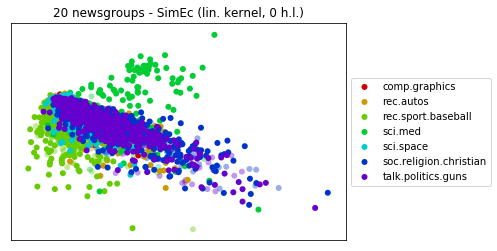

In [33]:
# project to 2d with linear similarity encoder
n_targets = 1000
simec = SimilarityEncoder(X.shape[1], 2, n_targets, sparse_inputs=True, l2_reg_emb=0.00001, 
                          l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                          opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, K_lin[:,:n_targets])
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_20news(X_embeds, y, target_names, X_embed_tests, y_test,
            title='20 newsgroups - SimEc (lin. kernel, 0 h.l.)', legend=True)
if savefigs: plt.savefig('fig_spectral_20news_lin_simec.png', dpi=300)
print "correlation with lin kPCA: %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_lin_test)

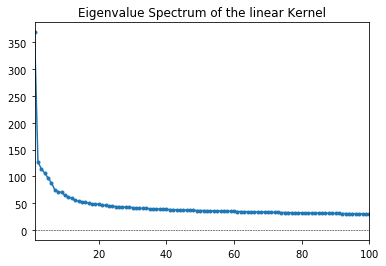

In [34]:
# check how many relevant dimensions there are - obviously at most # feature dim, not # of data points
eigenvals = np.linalg.eigvalsh(K_lin)[::-1]
plt.figure();
plt.plot(range(1, K_lin.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, K_lin.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the linear Kernel');

2
Epoch 1/25
3959/3959 [==============================] - 2s 513us/step - loss: 0.0837
Epoch 2/25
3959/3959 [==============================] - 1s 150us/step - loss: 0.0796
Epoch 3/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0786
Epoch 4/25
3959/3959 [==============================] - 1s 158us/step - loss: 0.0779
Epoch 5/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.0773
Epoch 6/25
3959/3959 [==============================] - 1s 145us/step - loss: 0.0768
Epoch 7/25
3959/3959 [==============================] - 1s 159us/step - loss: 0.0764
Epoch 8/25
3959/3959 [==============================] - 1s 157us/step - loss: 0.0761
Epoch 9/25
3959/3959 [==============================] - 1s 145us/step - loss: 0.0758
Epoch 10/25
3959/3959 [==============================] - 1s 160us/step - loss: 0.0755
Epoch 11/25
3959/3959 [==============================] - 1s 150us/step - loss: 0.0754
Epoch 12/25
3959/3959 [==============================] - 1s 1

3959/3959 [==============================] - 1s 155us/step - loss: 0.0686
Epoch 17/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0685
Epoch 18/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0684
Epoch 19/25
3959/3959 [==============================] - 1s 159us/step - loss: 0.0683
Epoch 20/25
3959/3959 [==============================] - 1s 160us/step - loss: 0.0682
Epoch 21/25
3959/3959 [==============================] - 1s 145us/step - loss: 0.0682
Epoch 22/25
3959/3959 [==============================] - 1s 152us/step - loss: 0.0681
Epoch 23/25
3959/3959 [==============================] - 1s 148us/step - loss: 0.0681
Epoch 24/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0680
Epoch 25/25
3959/3959 [==============================] - 1s 152us/step - loss: 0.0679
mse kpca: 0.029294 (0.039042); mse simec: 0.032113 (0.040929)
correlation with linear kPCA       : 0.843154
correlation with linear kPCA (test): 0.95512

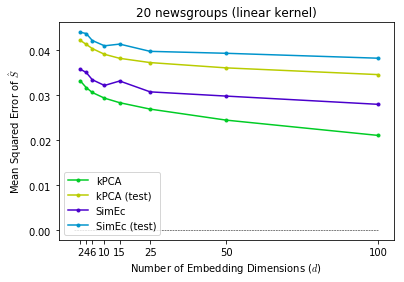

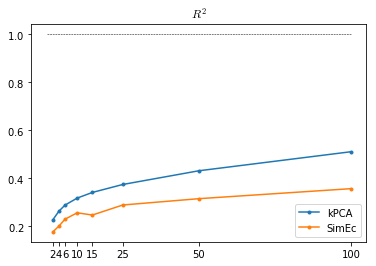

In [35]:
colors = get_colors(10)
mse_kpca, mse_kpca_test, rsq_kpca = [], [], []
mse_simec, mse_simec_test, rsq_simec = [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    kpca = KernelPCA(n_components=e_dim, kernel='linear')
    X_embed = kpca.fit_transform(X)
    X_embed_test = kpca.transform(X_test)
    mse_k, rsq, _ = check_similarity_match(X_embed, K_lin)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
    mse_kpca_test.append(mse_kt)
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, rsq, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
    print "correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
    print "correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[4], label='kPCA');
plt.plot(e_dims, mse_kpca_test, '-o', markersize=3, c=colors[2], label='kPCA (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(e_dims, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=3);
plt.title('20 newsgroups (linear kernel)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "e_dims=", e_dims
print "mse_kpca=", mse_kpca
print "mse_kpca_test=", mse_kpca_test
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_edim.pdf', dpi=300)
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, label='kPCA');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, label='SimEc');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.legend(loc=0);
plt.title('$R^2$');
plt.xticks(e_dims, e_dims);

100
Epoch 1/25
3959/3959 [==============================] - 2s 548us/step - loss: 0.4681
Epoch 2/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.4150
Epoch 3/25
3959/3959 [==============================] - 1s 148us/step - loss: 0.3862
Epoch 4/25
3959/3959 [==============================] - 1s 149us/step - loss: 0.3684
Epoch 5/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.3547
Epoch 6/25
3959/3959 [==============================] - 1s 146us/step - loss: 0.3437
Epoch 7/25
3959/3959 [==============================] - 1s 145us/step - loss: 0.3349
Epoch 8/25
3959/3959 [==============================] - 1s 136us/step - loss: 0.3274
Epoch 9/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.3206
Epoch 10/25
3959/3959 [==============================] - 1s 148us/step - loss: 0.3147
Epoch 11/25
3959/3959 [==============================] - 1s 158us/step - loss: 0.3093
Epoch 12/25
3959/3959 [==============================] - 1s

3959/3959 [==============================] - 1s 145us/step - loss: 0.0800
Epoch 17/25
3959/3959 [==============================] - 1s 148us/step - loss: 0.0799
Epoch 18/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.0797
Epoch 19/25
3959/3959 [==============================] - 1s 142us/step - loss: 0.0796
Epoch 20/25
3959/3959 [==============================] - 1s 148us/step - loss: 0.0795
Epoch 21/25
3959/3959 [==============================] - 1s 155us/step - loss: 0.0795
Epoch 22/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.0794
Epoch 23/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0793
Epoch 24/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.0792
Epoch 25/25
3959/3959 [==============================] - 1s 151us/step - loss: 0.0791
mse kpca: 0.029294 (0.039042); mse simec: 0.032200 (0.041076)
correlation with linear kPCA       : 0.791700
correlation with linear kPCA (test): 0.94734

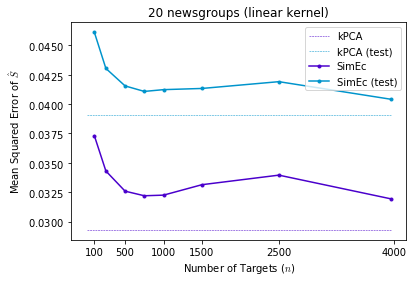

In [36]:
# check effect of different number of targets
colors = get_colors(10)
mse_simec, mse_simec_test = [], []
targets = [100, 250, 500, 750, 1000, 1500, 2500, K_lin.shape[1]]
e_dim = 10
kpca = KernelPCA(n_components=e_dim, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k, _, _ = check_similarity_match(X_embed, K_lin)
mse_kt, _, _ = check_similarity_match(X_embed_test, K_lin_test)
for n in targets:
    print n
    simec = SimilarityEncoder(X.shape[1], e_dim, n, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin[:n,:n],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin[:,:n])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse, _, _ = check_similarity_match(X_embeds, K_lin)
    mse_simec.append(mse)
    mse_t, _, _ = check_similarity_match(X_embed_tests, K_lin_test)
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
    print "correlation with linear kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
    print "correlation with linear kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
plt.figure();
plt.plot([0, targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('20 newsgroups (linear kernel)');
plt.xticks([100, 500, 1000, 1500, 2500, 4000], [100, 500, 1000, 1500, 2500, 4000]);
plt.xlabel('Number of Targets ($n$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "targets=", targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_ntargets.pdf', dpi=300)

0.0
Epoch 1/25
3959/3959 [==============================] - 2s 592us/step - loss: 0.0802
Epoch 2/25
3959/3959 [==============================] - 1s 173us/step - loss: 0.0758
Epoch 3/25
3959/3959 [==============================] - 1s 166us/step - loss: 0.0738
Epoch 4/25
3959/3959 [==============================] - 1s 160us/step - loss: 0.0726
Epoch 5/25
3959/3959 [==============================] - 1s 154us/step - loss: 0.0718
Epoch 6/25
3959/3959 [==============================] - 1s 159us/step - loss: 0.0712
Epoch 7/25
3959/3959 [==============================] - 1s 152us/step - loss: 0.0707
Epoch 8/25
3959/3959 [==============================] - 1s 164us/step - loss: 0.0702
Epoch 9/25
3959/3959 [==============================] - 1s 163us/step - loss: 0.0699
Epoch 10/25
3959/3959 [==============================] - 1s 160us/step - loss: 0.0696
Epoch 11/25
3959/3959 [==============================] - 1s 166us/step - loss: 0.0693
Epoch 12/25
3959/3959 [==============================] - 1s

3959/3959 [==============================] - 1s 172us/step - loss: 0.0677
Epoch 12/25
3959/3959 [==============================] - 1s 170us/step - loss: 0.0674
Epoch 13/25
3959/3959 [==============================] - 1s 168us/step - loss: 0.0670
Epoch 14/25
3959/3959 [==============================] - 1s 170us/step - loss: 0.0666
Epoch 15/25
3959/3959 [==============================] - 1s 162us/step - loss: 0.0663
Epoch 16/25
3959/3959 [==============================] - 1s 164us/step - loss: 0.0661
Epoch 17/25
3959/3959 [==============================] - 1s 163us/step - loss: 0.0658
Epoch 18/25
3959/3959 [==============================] - 1s 164us/step - loss: 0.0655
Epoch 19/25
3959/3959 [==============================] - 1s 170us/step - loss: 0.0652
Epoch 20/25
3959/3959 [==============================] - 1s 165us/step - loss: 0.0649
Epoch 21/25
3959/3959 [==============================] - 1s 164us/step - loss: 0.0647
Epoch 22/25
3959/3959 [==============================] - 1s 168us/

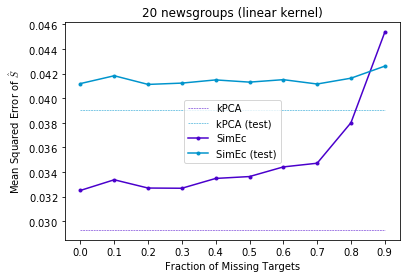

In [37]:
# check effect of missing target values
n_targets = 1000
np.random.seed(10)
colors = get_colors(10)
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_lin)[0]
mse_kt = check_similarity_match(X_embed_test, K_lin_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for m in missing_targets:
    print m
    K_lin_noisy = K_lin.copy()
    K_lin_noisy[np.random.rand(*K_lin_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], 10, n_targets, mask_value=-100, sparse_inputs=True, l2_reg_emb=0.00001, 
                              l2_reg_out=0.00000001, s_ll_reg=0.5, S_ll=K_lin_noisy[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.005))
    simec.fit(X, K_lin_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_lin)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_lin_test)[0]
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('20 newsgroups (linear kernel)');
plt.xticks(missing_targets, missing_targets);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "missing_targets=", missing_targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_spectral_20news_lin_mse_missingt.pdf', dpi=300)